In [1]:
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.model_selection import cross_validate
import xgboost as xgb
from sklearn.model_selection import GridSearchCV

In [2]:
df1 = pd.read_csv("E:\MDA 2023\Full noise data\Jan\csv_results_42_255443_mp-06-parkstraat-2-la-filosovia.csv",delimiter=';')
df1 = df1[['result_timestamp','laeq']]
df2 = pd.read_csv("E:\MDA 2023\Full noise data\Feb\csv_results_42_255443_mp-06-parkstraat-2-la-filosovia.csv",delimiter=';')
df2 = df2[['result_timestamp','laeq']]
df3 = pd.read_csv("E:\MDA 2023\Full noise data\March\csv_results_44_255443_mp-06-parkstraat-2-la-filosovia.csv",delimiter=';')
df3 = df3[['result_timestamp','laeq']]
df4 = pd.read_csv("E:\MDA 2023\Full noise data\April\csv_results_45_255443_mp-06-parkstraat-2-la-filosovia.csv",delimiter=';')
df4 = df4[['result_timestamp','laeq']]
df5 = pd.read_csv("E:\MDA 2023\Full noise data\May\csv_results_46_255443_mp-06-parkstraat-2-la-filosovia.csv",delimiter=';')
df5 = df5[['result_timestamp','laeq']]
df6 = pd.read_csv("E:\MDA 2023\Full noise data\June\csv_results_47_255443_mp-06-parkstraat-2-la-filosovia.csv",delimiter=';')
df6 = df6[['result_timestamp','laeq']]
df7 = pd.read_csv("E:\MDA 2023\Full noise data\Jul\csv_results_48_255443_mp-06-parkstraat-2-la-filosovia.csv",delimiter=';')
df7 = df7[['result_timestamp','laeq']]
df8 = pd.read_csv("E:\MDA 2023\Full noise data\Aug\csv_results_49_255443_mp-06-parkstraat-2-la-filosovia.csv",delimiter=';')
df8 = df8[['result_timestamp','laeq']]
df9 = pd.read_csv("E:\MDA 2023\Full noise data\Sep\csv_results_50_255443_mp-06-parkstraat-2-la-filosovia.csv",delimiter=';')
df9 = df9[['result_timestamp','laeq']]
df10 = pd.read_csv("E:\MDA 2023\Full noise data\Oct\csv_results_51_255443_mp-06-parkstraat-2-la-filosovia.csv",delimiter=';')
df10 = df10[['result_timestamp','laeq']]
df11 = pd.read_csv("E:\MDA 2023\Full noise data\\Nov\csv_results_52_255443_mp-06-parkstraat-2-la-filosovia.csv",delimiter=';')
df11 = df11[['result_timestamp','laeq']]
df12 = pd.read_csv("E:\MDA 2023\Full noise data\Dec\csv_results_53_255443_mp-06-parkstraat-2-la-filosovia.csv",delimiter=';')
df12 = df12[['result_timestamp','laeq']]
dfn = pd.concat([df1,df2,df3,df4,df5,df6,df7,df8,df9,df10,df11,df12], axis=0)

In [3]:
# Convert noise datetime column to a Pandas datetime object
dfn['result_timestamp'] = pd.to_datetime(dfn['result_timestamp'], format="%d/%m/%Y %H:%M:%S.%f")
df_backup = dfn

In [4]:
#dfn = df_backup

In [5]:
# set timestamp column as the index
dfn.set_index('result_timestamp', inplace=True)

In [6]:
# resample to one minute frequency and aggregate using the mean
dfn = dfn.resample('10T').mean()

In [7]:
# Drop the datetime column from the index and reset the index to default
dfn = dfn.reset_index()
dfn

,result_timestamp,laeq
0,2022-01-01 00:00:00,54.790667
1,2022-01-01 00:10:00,48.605833
2,2022-01-01 00:20:00,54.277833
3,2022-01-01 00:30:00,50.025333
4,2022-01-01 00:40:00,48.907333
...,...,...
52555,2022-12-31 23:10:00,52.203333
52556,2022-12-31 23:20:00,54.622833
52557,2022-12-31 23:30:00,56.135667
52558,2022-12-31 23:40:00,59.380333


In [8]:
# Extract minute-in-the-hour feature (makes model slightly less accurate)
#dfn['minute'] = dfn['result_timestamp'].dt.minute.astype('int64')

# Extract hour-in-the-day feature
dfn['hour'] = dfn['result_timestamp'].dt.hour.astype('int64')

# Extract day-in-the-week feature
dfn['weekday'] = dfn['result_timestamp'].dt.dayofweek.astype('int64')

# Extract day-in-the-month feature
dfn['day_of_month'] = dfn['result_timestamp'].dt.day.astype('int64')

# Extract month-in-the-year feature
dfn['month'] = dfn['result_timestamp'].dt.month.astype('int64')

In [9]:
#create numeric columns to merge on
dfn['result_timestamp'] = dfn['result_timestamp'].astype('int64')
dfn

,result_timestamp,laeq,hour,weekday,day_of_month,month
0,1640995200000000000,54.790667,0,5,1,1
1,1640995800000000000,48.605833,0,5,1,1
2,1640996400000000000,54.277833,0,5,1,1
3,1640997000000000000,50.025333,0,5,1,1
4,1640997600000000000,48.907333,0,5,1,1
...,...,...,...,...,...,...
52555,1672528200000000000,52.203333,23,5,31,12
52556,1672528800000000000,54.622833,23,5,31,12
52557,1672529400000000000,56.135667,23,5,31,12
52558,1672530000000000000,59.380333,23,5,31,12


In [10]:
#get weather data
dfw1 = pd.read_csv("E:\MDA 2023\dataverse_files\LC_2022Q1.csv")
dfw1 = dfw1[dfw1['ID'] == 'LC-105']
dfw2 = pd.read_csv("E:\MDA 2023\dataverse_files\LC_2022Q2.csv")
dfw2 = dfw2[dfw2['ID'] == 'LC-105']
dfw3 = pd.read_csv("E:\MDA 2023\dataverse_files\LC_2022Q3.csv")
dfw3 = dfw3[dfw3['ID'] == 'LC-105']
dfw4 = pd.read_csv("E:\MDA 2023\dataverse_files\LC_2022Q4.csv")
dfw4 = dfw4[dfw4['ID'] == 'LC-105']
dfw = pd.concat([dfw1,dfw2,dfw3,dfw4],axis=0)
dfw = dfw[['DATEUTC', 'LC_HUMIDITY', 'LC_DWPTEMP', 'LC_n', 'LC_RAD', 'LC_RAININ', 'LC_DAILYRAIN','LC_WINDDIR',
          'LC_WINDSPEED', 'LC_RAD60', 'LC_TEMP_QCL0','LC_TEMP_QCL1','LC_TEMP_QCL2','LC_TEMP_QCL3']]

dfw['result_timestamp'] = dfw['DATEUTC']
dfw = dfw.drop(['DATEUTC'], axis=1)
dfw['result_timestamp'] = pd.to_datetime(dfw['result_timestamp'],format="%Y-%m-%d %H:%M:%S")
dfw['result_timestamp'] = dfw['result_timestamp'].astype('int64')
dfw = dfw[dfw.isnull()['LC_HUMIDITY']==False]
dfw = dfw[dfw['result_timestamp'].duplicated()==False]
dfw.duplicated().sum()

0

In [11]:
#merge noise and weather data
df = pd.merge(dfn,dfw,on='result_timestamp', validate="1:1")

In [12]:
df['result_timestamp'] = pd.to_datetime(df['result_timestamp'])
df

,result_timestamp,laeq,hour,weekday,day_of_month,month,LC_HUMIDITY,LC_DWPTEMP,LC_n,LC_RAD,LC_RAININ,LC_DAILYRAIN,LC_WINDDIR,LC_WINDSPEED,LC_RAD60,LC_TEMP_QCL0,LC_TEMP_QCL1,LC_TEMP_QCL2,LC_TEMP_QCL3
0,2022-01-01 00:10:00,48.605833,0,5,1,1,91.0,11.88,38.0,0.0,0.0,0.0,-48.0,0.04,0.0,13.28,13.28,13.223,13.23639
1,2022-01-01 00:20:00,54.277833,0,5,1,1,90.0,11.72,37.0,0.0,0.0,0.0,45.0,0.02,0.0,13.28,13.28,13.223,13.16699
2,2022-01-01 00:30:00,50.025333,0,5,1,1,90.0,11.72,38.0,0.0,0.0,0.0,-52.0,0.04,0.0,13.28,13.28,13.223,13.19886
3,2022-01-01 00:40:00,48.907333,0,5,1,1,90.0,11.72,37.0,0.0,0.0,0.0,34.0,0.02,0.0,13.28,13.28,13.223,13.16699
4,2022-01-01 00:50:00,47.905000,0,5,1,1,90.0,11.72,38.0,0.0,0.0,0.0,0.0,0.00,0.0,13.28,13.28,13.223,13.09212
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52548,2022-12-31 23:10:00,52.203333,23,5,31,12,52.0,6.79,38.0,0.0,0.0,0.0,-9.0,0.40,0.0,16.61,16.61,16.553,16.52797
52549,2022-12-31 23:20:00,54.622833,23,5,31,12,52.0,6.74,38.0,0.0,0.0,0.0,5.0,0.29,0.0,16.61,16.61,16.553,16.57995
52550,2022-12-31 23:30:00,56.135667,23,5,31,12,52.0,6.62,37.0,0.0,0.0,0.0,-17.0,0.15,0.0,16.51,16.51,16.453,16.44846
52551,2022-12-31 23:40:00,59.380333,23,5,31,12,52.0,6.60,38.0,0.0,0.0,0.0,-31.0,0.29,0.0,16.49,16.49,16.433,16.46641


In [13]:
# check for missings
df.isnull().sum()

result_timestamp     0
laeq                84
hour                 0
weekday              0
day_of_month         0
month                0
LC_HUMIDITY          0
LC_DWPTEMP           0
LC_n                 0
LC_RAD               0
LC_RAININ            0
LC_DAILYRAIN         0
LC_WINDDIR           0
LC_WINDSPEED         0
LC_RAD60             0
LC_TEMP_QCL0         0
LC_TEMP_QCL1        54
LC_TEMP_QCL2        54
LC_TEMP_QCL3        54
dtype: int64

In [14]:
# only keep rows without missings
df=df[df.isnull()['LC_TEMP_QCL2']==False]
df=df[df.isnull()['laeq']==False]

In [15]:
#doublecheck whether missings are gone
df.isnull().sum()

result_timestamp    0
laeq                0
hour                0
weekday             0
day_of_month        0
month               0
LC_HUMIDITY         0
LC_DWPTEMP          0
LC_n                0
LC_RAD              0
LC_RAININ           0
LC_DAILYRAIN        0
LC_WINDDIR          0
LC_WINDSPEED        0
LC_RAD60            0
LC_TEMP_QCL0        0
LC_TEMP_QCL1        0
LC_TEMP_QCL2        0
LC_TEMP_QCL3        0
dtype: int64

In [16]:
# Drop the datetime column
df_nd = df.drop('result_timestamp', axis=1)

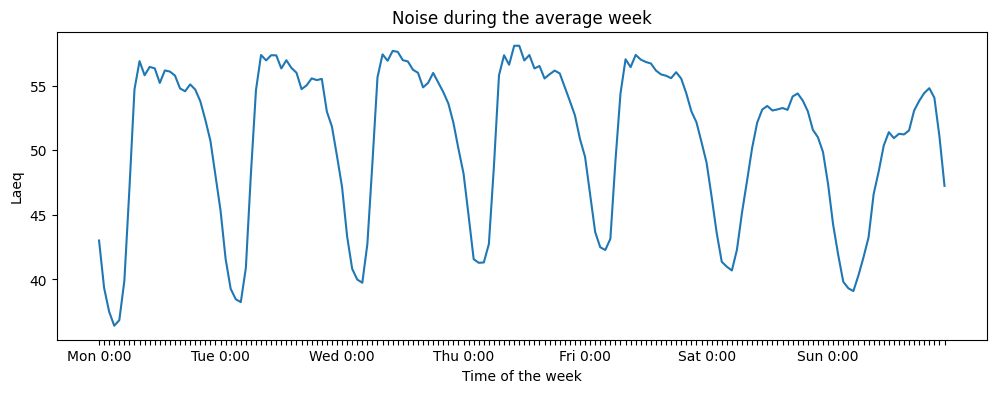

In [17]:
fig, ax = plt.subplots(figsize=(12, 4))
average_week_noise = df_nd.groupby(["weekday", "hour"])["laeq"].mean()
average_week_noise.plot(ax=ax)
_ = ax.set(
    title="Noise during the average week",
    xticks=range(168),
    xticklabels=["Mon 0:00", "", "", "", "", "", "", "", "", "", "", "",
                  "", "", "", "", "", "", "", "", "", "", "", "",
                 "Tue 0:00", "", "", "", "", "", "", "", "", "", "", "",
                  "", "", "", "", "", "", "", "", "", "", "", "",
                 "Wed 0:00", "", "", "", "", "", "", "", "", "", "", "",
                  "", "", "", "", "", "", "", "", "", "", "", "",
                 "Thu 0:00", "", "", "", "", "", "", "", "", "", "", "",
                  "", "", "", "", "", "", "", "", "", "", "", "",
                 "Fri 0:00", "", "", "", "", "", "", "", "", "", "", "",
                  "", "", "", "", "", "", "", "", "", "", "", "",
                 "Sat 0:00", "", "", "", "", "", "", "", "", "", "", "",
                  "", "", "", "", "", "", "", "", "", "", "", "",
                 "Sun 0:00", "", "", "", "", "", "", "", "", "", "", "",
                  "", "", "", "", "", "", "", "", "", "", "", "",
                ],
    xlabel="Time of the week",
    ylabel="Laeq",
)

fig.savefig("Noise_average_week_feb2.png")


In [18]:
#convert noise to relative noise (or relative crowdedness) as target (y), create dataframe with predictors only (X)
y = df_nd["laeq"] / df_nd["laeq"].max()
X = df_nd.drop("laeq", axis="columns")

In [72]:
#create time-sensitive split for cross-validation
ts_cv = TimeSeriesSplit(
    n_splits=5,
    gap=4320,
    max_train_size=10000,
    test_size=1000,
)

In [73]:
#inspect splits
all_splits = list(ts_cv.split(X, y))
train_0, test_0 = all_splits[0]
X.iloc[test_0]
X.iloc[train_0]

,hour,weekday,day_of_month,month,LC_HUMIDITY,LC_DWPTEMP,LC_n,LC_RAD,LC_RAININ,LC_DAILYRAIN,LC_WINDDIR,LC_WINDSPEED,LC_RAD60,LC_TEMP_QCL0,LC_TEMP_QCL1,LC_TEMP_QCL2,LC_TEMP_QCL3
33200,14,4,19,8,62.0,17.53,31.0,320.0,0.0,0.0,-50.0,0.14,340.0,25.38,25.38,25.323,24.515550
33201,14,4,19,8,62.0,17.76,32.0,214.0,0.0,0.0,-47.0,0.18,340.0,25.65,25.65,25.593,24.879817
33202,14,4,19,8,63.0,18.17,31.0,144.0,0.0,0.0,-56.0,0.09,297.0,25.77,25.77,25.713,24.841102
33203,14,4,19,8,63.0,18.23,32.0,227.0,0.0,0.0,-16.0,0.27,217.0,25.70,25.70,25.643,25.030046
33204,14,4,19,8,62.0,17.77,32.0,356.0,0.0,0.0,-43.0,0.13,281.0,25.51,25.51,25.453,24.728112
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43206,2,4,28,10,80.0,13.72,38.0,0.0,0.0,0.0,0.0,0.00,0.0,17.22,17.22,17.163,17.025330
43207,2,4,28,10,82.0,13.86,37.0,0.0,0.0,0.0,0.0,0.00,0.0,17.03,17.03,16.973,16.817900
43208,2,4,28,10,82.0,13.73,38.0,0.0,0.0,0.0,0.0,0.00,0.0,16.81,16.81,16.753,16.602790
43209,2,4,28,10,83.0,13.65,37.0,0.0,0.0,0.0,0.0,0.00,0.0,16.58,16.58,16.523,16.371440


In [74]:
train_4, test_4 = all_splits[4]
X.iloc[test_4]
X.iloc[train_4]

,hour,weekday,day_of_month,month,LC_HUMIDITY,LC_DWPTEMP,LC_n,LC_RAD,LC_RAININ,LC_DAILYRAIN,LC_WINDDIR,LC_WINDSPEED,LC_RAD60,LC_TEMP_QCL0,LC_TEMP_QCL1,LC_TEMP_QCL2,LC_TEMP_QCL3
37202,9,4,16,9,84.0,10.78,32.0,120.0,0.000,0.000,86.0,0.04,114.0,13.35,13.35,13.293,13.079184
37203,9,4,16,9,85.0,11.00,32.0,43.0,0.001,0.001,17.0,0.14,92.0,13.50,13.50,13.443,13.232738
37204,9,4,16,9,88.0,11.49,31.0,84.0,0.002,0.001,139.0,0.13,73.0,13.44,13.44,13.383,13.289589
37205,9,4,16,9,89.0,11.47,32.0,121.0,0.000,0.001,-26.0,0.06,100.0,13.29,13.29,13.233,13.158517
37206,9,4,16,9,88.0,11.22,32.0,172.0,0.000,0.001,-137.0,0.03,114.0,13.16,13.16,13.103,13.078824
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47221,23,3,24,11,83.0,8.27,37.0,0.0,0.000,0.000,31.0,0.15,0.0,11.11,11.11,11.053,11.154330
47222,23,3,24,11,83.0,8.34,38.0,0.0,0.000,0.000,72.0,0.19,0.0,11.18,11.18,11.123,11.202350
47223,23,3,24,11,83.0,8.45,37.0,0.0,0.000,0.000,33.0,0.19,0.0,11.25,11.25,11.193,11.275580
47224,23,3,24,11,83.0,8.50,38.0,0.0,0.000,0.000,60.0,0.17,0.0,11.28,11.28,11.223,11.326510


In [75]:
#run histogram gradient boosting model
def evaluate(model, X, y, cv):
    cv_results = cross_validate(
        model,
        X,
        y,
        cv=cv,
        scoring=["neg_mean_absolute_error", "neg_root_mean_squared_error"],
    )
    mae = -cv_results["test_neg_mean_absolute_error"]
    rmse = -cv_results["test_neg_root_mean_squared_error"]
    print(
        f"Mean Absolute Error:     {mae.mean():.3f} +/- {mae.std():.3f}\n"
        f"Root Mean Squared Error: {rmse.mean():.3f} +/- {rmse.std():.3f}"
    )

gbrt_pipeline = make_pipeline(xgb.XGBRegressor(learning_rate=0.03,n_estimators=80,max_depth=4)).set_output(transform="pandas")

evaluate(gbrt_pipeline, X, y, cv=ts_cv)

Mean Absolute Error:     0.035 +/- 0.011
Root Mean Squared Error: 0.044 +/- 0.011


In [76]:
# grid search for hyperparameter tuning

param_grid = {
    'learning_rate': (0.03, 0.04),
    'n_estimators': (60, 80),
    'max_depth' : (3,4)}
model = xgb.XGBRegressor()
model_grid_search = GridSearchCV(model, param_grid=param_grid,
                                 n_jobs=2, cv=ts_cv)
model_grid_search.fit(X, y)


GridSearchCV(cv=TimeSeriesSplit(gap=4320, max_train_size=10000, n_splits=5, test_size=1000),
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None, gpu_id=None,
                                    grow_policy=None...
                                    learning_rate=None, max_bin=None,
                                    max_cat_threshold=None,
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None, n_estimators=100,
                                    n_jobs=None, num_parallel_tree=None,
                                    predictor=None, random_state=None, ...),
             n_jobs=2,
             param_grid={'learning_rate': (0.03, 0.04), 'max_depth': (3, 4),
                         'n_estimators': (60, 80)})

In [77]:
accuracy = model_grid_search.score(X, y)
print(
    f"The test accuracy score of the grid-searched pipeline is: "
    f"{accuracy:.2f}"
)

The test accuracy score of the grid-searched pipeline is: 0.66


In [78]:
model_grid_search.predict(X.iloc[0:5])

array([0.5482373 , 0.54231805, 0.54231805, 0.54231805, 0.5374882 ],
      dtype=float32)

In [79]:
print(f"The best set of parameters is: "
      f"{model_grid_search.best_params_}")

The best set of parameters is: {'learning_rate': 0.03, 'max_depth': 4, 'n_estimators': 60}


In [80]:
cv_results = pd.DataFrame(model_grid_search.cv_results_).sort_values(
    "mean_test_score", ascending=False)
cv_results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,param_max_depth,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
2,0.509907,0.039137,0.005487,0.000446,0.03,4,60,"{'learning_rate': 0.03, 'max_depth': 4, 'n_est...",0.755601,0.677309,0.787644,0.740847,0.444724,0.681225,0.123580,1
0,0.374555,0.017234,0.005985,0.001094,0.03,3,60,"{'learning_rate': 0.03, 'max_depth': 3, 'n_est...",0.743438,0.700462,0.772385,0.728426,0.458185,0.680579,0.113599,2
1,0.434811,0.007124,0.006189,0.000507,0.03,3,80,"{'learning_rate': 0.03, 'max_depth': 3, 'n_est...",0.770779,0.753810,0.782272,0.730738,0.305705,0.668661,0.182305,3
4,0.359716,0.009872,0.005384,0.001351,0.04,3,60,"{'learning_rate': 0.04, 'max_depth': 3, 'n_est...",0.771174,0.752602,0.779158,0.729481,0.309391,0.668361,0.180299,4
3,0.611212,0.059621,0.005886,0.000662,0.03,4,80,"{'learning_rate': 0.03, 'max_depth': 4, 'n_est...",0.762047,0.735525,0.795077,0.735583,0.265894,0.658825,0.197681,5


In [81]:
# get the parameter names
column_results = [f"param_{name}" for name in param_grid.keys()]
column_results += [
    "mean_test_score", "std_test_score", "rank_test_score"]
cv_results = cv_results[column_results]

In [82]:
def shorten_param(param_name):
    if "__" in param_name:
        return param_name.rsplit("__", 1)[1]
    return param_name


cv_results = cv_results.rename(shorten_param, axis=1)
cv_results

,param_learning_rate,param_n_estimators,param_max_depth,mean_test_score,std_test_score,rank_test_score
2,0.03,60,4,0.681225,0.123580,1
0,0.03,60,3,0.680579,0.113599,2
1,0.03,80,3,0.668661,0.182305,3
4,0.04,60,3,0.668361,0.180299,4
3,0.03,80,4,0.658825,0.197681,5
6,0.04,60,4,0.658225,0.199049,6
5,0.04,80,3,0.621051,0.239005,7
7,0.04,80,4,0.614592,0.250129,8


In [83]:
pivoted_cv_results = cv_results.pivot_table(
    values="mean_test_score", index=["param_learning_rate"],
    columns=["param_n_estimators"])

pivoted_cv_results

param_n_estimators,60,80
param_learning_rate,,
0.03,0.680902,0.663743
0.04,0.663293,0.617821


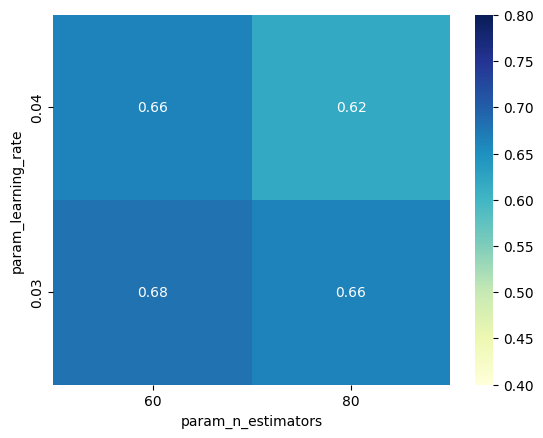

In [84]:
import seaborn as sns

ax = sns.heatmap(pivoted_cv_results, annot=True, cmap="YlGnBu", vmin=0.4,
                 vmax=0.8)
ax.invert_yaxis()

In [85]:
#feature importance
xgb_reg = xgb.XGBRegressor(learning_rate=0.02,n_estimators=120,max_depth=5, importance_type='gain').fit(X,y)
xgb_reg.get_booster().get_score(importance_type='gain')


{'hour': 6.071299076080322,
 'weekday': 1.0105966329574585,
 'day_of_month': 0.1958562731742859,
 'month': 0.3185432553291321,
 'LC_HUMIDITY': 0.14106738567352295,
 'LC_DWPTEMP': 0.12234407663345337,
 'LC_n': 0.3997546136379242,
 'LC_RAD': 0.40235990285873413,
 'LC_RAININ': 0.08407360315322876,
 'LC_DAILYRAIN': 0.1714649349451065,
 'LC_WINDDIR': 0.00480643892660737,
 'LC_WINDSPEED': 0.0312269926071167,
 'LC_RAD60': 0.14783704280853271,
 'LC_TEMP_QCL0': 0.08438627421855927,
 'LC_TEMP_QCL3': 0.210223987698555}

In [86]:
weight = xgb_reg.get_booster().get_score(importance_type='weight')
gain = xgb_reg.get_booster().get_score(importance_type='gain')
cover = xgb_reg.get_booster().get_score(importance_type='cover')
total_gain = xgb_reg.get_booster().get_score(importance_type='total_gain')
total_cover = xgb_reg.get_booster().get_score(importance_type='total_cover')

f_importance_weight = xgb_reg.get_booster().get_score(importance_type='weight')
importance_df_weight = pd.DataFrame.from_dict(data=f_importance_weight, 
                                       orient='index')
f_importance_gain = xgb_reg.get_booster().get_score(importance_type='gain')
importance_df_gain = pd.DataFrame.from_dict(data=f_importance_gain, 
                                       orient='index')
f_importance_cover = xgb_reg.get_booster().get_score(importance_type='cover')
importance_df_cover = pd.DataFrame.from_dict(data=f_importance_cover, 
                                       orient='index')
f_importance_total_gain = xgb_reg.get_booster().get_score(importance_type='total_gain')
importance_df_total_gain = pd.DataFrame.from_dict(data=f_importance_total_gain, 
                                       orient='index')
f_importance_total_cover = xgb_reg.get_booster().get_score(importance_type='total_cover')
importance_df_total_cover = pd.DataFrame.from_dict(data=f_importance_total_cover, 
                                       orient='index')

feature_importance = pd.concat([importance_df_weight, importance_df_gain, importance_df_cover, importance_df_total_gain, importance_df_total_cover], axis=1)
feature_importance

,0,0,0,0,0
hour,1010.0,6.071299,15514.014648,6132.012207,15669155.0
weekday,766.0,1.010597,8520.459961,774.117065,6526672.0
day_of_month,244.0,0.195856,3138.733643,47.788929,765851.0
month,754.0,0.318543,5810.348633,240.181610,4381003.0
LC_HUMIDITY,163.0,0.141067,4748.607422,22.993984,774023.0
LC_DWPTEMP,158.0,0.122344,1392.557007,19.330364,220024.0
LC_n,36.0,0.399755,6407.555664,14.391166,230672.0
LC_RAD,84.0,0.402360,11064.404297,33.798233,929410.0
LC_RAININ,3.0,0.084074,8911.000000,0.252221,26733.0
LC_DAILYRAIN,144.0,0.171465,7350.395996,24.690950,1058457.0
